In [2]:
import PIL.Image as pil_image
import glob
import json
from collections import defaultdict
import scipy.io
import numpy as np
import os
import random
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.utils import np_utils
from keras.models import load_model,Model
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras import layers
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [3]:
with open('./start/bba/bb.npy') as f:
    bb_list = np.load(f)

In [2]:
# setting
#(img_height, img_width)
crop_size = (224, 224)
data_dir = './start/'
shuffle = True
alpha = 0.5

## Utils

In [5]:
def original(img):
    tmp = np.zeros_like(img)
    for i in range(3):
        tmp[:,:,i] = img[:,:,i] - img[:,:,i].min()
    return tmp.astype(np.uint8)

def lookup(d, key, i):
    if key == 'make+model':
        for item in d:
            if item['pp_brand_id']+' '+item['pp_genre_id'] == i:
                return item['chinese']
    else:
        for item in d:
            if item[key] == i:
                return item['chinese']
            
def crop_img(img, box):
    """
    box: left, top, right, bottom
    """
    w, h = img.size
    box = [box[0]*w, box[1]*h,box[2]*w,box[3]*h]
    return img.crop(box)
            
def load_img(path, grayscale=False, target_size=None, box=None):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        box: The crop rectangle, as a (left, upper, right, lower)-tuple.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if box:
        img = crop_img(img, box)
        
    if target_size:
        hw_tuple = (target_size[1], target_size[0])
        #resize(w, h)
        if img.size != hw_tuple:
            img = img.resize(hw_tuple)
    return img
            
def load_data(image_paths, labels, num_of_class=10, target_size=(227, 227), box=None):
    """
    Given list of paths, load images as one numpy array of shape
        (num_images, crop_size, crop_size, channel)
    :return X: image array
    "return y: one hot encoded labels
    """
    if box:
        X = np.zeros((len(image_paths), crop_size[0],crop_size[1], 3))
        ## google output box :## 0: top 1: left 2 lower 3 right
        for i,path in enumerate(image_paths):
            new_box = (box[i][1],box[i][0],box[i][3], box[i][2])
            X[i, :] = img_to_array(load_img(path, target_size=crop_size, box=new_box))
        y = np_utils.to_categorical(labels, num_of_class)
        return X, y
    else:
        X = np.zeros((len(image_paths), crop_size[0],crop_size[1], 3))
        for i,path in enumerate(image_paths):
            X[i, :] = img_to_array(load_img(path, target_size=crop_size))
        y = np_utils.to_categorical(labels, num_of_class)
        return X, y
    
def judge_box(left, right, left_t=0.5, right_t=0.5):
    if left < left_t and right > right_t:
        return True

def load_box(path='./start/bba/bb.npy',x_threshold=0.5,x_threshold2=0.5):
    if x_threshold > x_threshold2:
        print 'threshold error'
    with open(path) as f:
        bb_list = np.load(f)
    bb_list = bb_list.item()
    result = defaultdict(list)
    ## delete left > 0.5 right border < 0.5
    ## 0: top 1: left 2 lower 3 right
    for k in bb_list.keys():
        if len(bb_list[k]) == 1:
            result[k] = bb_list[k]
            continue
        for bb_box in bb_list[k]:
            if judge_box(left=bb_box[1], right=bb_box[3], left_t=x_threshold, right_t=x_threshold2):
                result[k].append(bb_box)
    return result


## Loading data

In [6]:
train_paths = []
train_labels = []
train_makes = []
train_models = []
train_types = []

val_paths = []
val_labels = []
val_makes = []
val_models = []
val_types = []
# indentify make/model/car_id.jpg
makes = os.listdir(data_dir)
makes.remove('bba')
for make in makes:
    models = os.listdir(os.path.join(data_dir, make))
    for model in models:
        #pics = glob.glob(os.path.join(data_dir, make, model))
        pics = glob.glob(os.path.join(data_dir, make, model)+'/*_b.jpg')
        if len(pics)<3:
            continue
        #print (len(pics))
        split = len(pics)*4/5
        # train data
        for pic in pics[:split]:
            # two pic in a row
            train_paths += [pic[:-6] + '.jpg' + ' ' + pic]
            # label|
            train_models += [make + ' ' +model]
            train_makes += [make]
        
        #validation data
        for pic in pics[split:]:
            # two pic in a row
            val_paths += [pic[:-6] + '.jpg' + ' ' + pic]
            # label|
            val_models += [make + ' ' +model]
            val_makes += [make]

num_of_inst = len(train_makes)
assert(len(train_makes) == len(train_paths))

#indexing building
l2i_makes = sorted(list(set(train_makes + ['-1'])))
l2i_models = sorted(list(set(train_models + ['-1'])))

# for multiple label
train_labels.append([])
for item in train_makes:
    train_labels[0].append(l2i_makes.index(item))

train_labels.append([])
for item in train_models:
    train_labels[1].append(l2i_models.index(item))

val_labels.append([])
for item in val_makes:
    val_labels[0].append(l2i_makes.index(item))

val_labels.append([])
for item in val_models:
    val_labels[1].append(l2i_models.index(item))

if shuffle == True :
    idx = list(range(len(train_labels[0])))
    random.shuffle (idx)
    train_labels = np.array(train_labels)
    train_paths = np.array(train_paths)
    train_labels[0] = train_labels[0][idx]
    train_labels[1] = train_labels[1][idx]
    train_paths = train_paths[idx]
    train_labels = list(train_labels)
    train_paths = list(train_paths)

num_of_models = len(l2i_models)
num_of_makes = len(l2i_makes)
print (l2i_models)
num_of_train = len(train_labels[0])



##genere list
genere_list = [json.loads(line) for line in open('./start/bba/genre_list.json')]

## box_list
box_list =load_box()
##special case attention
box_list['1/50/441568_b.jpg'].append([ 0.23515469,  0.07656217,  0.9309997 ,  0.91154039])

['-1', '1 1', '1 1135', '1 1136', '1 1218', '1 1306', '1 16', '1 17', '1 20', '1 20010', '1 20141', '1 20159', '1 20173', '1 20241', '1 22', '1 2434', '1 2459', '1 2461', '1 2472', '1 416', '1 426', '1 439', '1 47', '1 48', '1 49', '1 50', '1 51', '1 52', '1 54', '1 57', '10 20019', '10 20021', '10 2454', '10 62', '10 685', '10 69', '10 75', '10 78', '11 1067', '11 150', '11 152', '11 169', '11 20023', '11 20024', '11 20136', '11 2422', '11 2507', '11 2513', '11 37', '11 84', '11 86', '11 989', '11 990', '12 1221', '12 1224', '12 20003', '12 2458', '12 55', '12 56', '12 58', '12 59', '12 60', '12 61', '12 63', '12 64', '12 65', '12 67', '12 68', '13 1025', '13 1311', '13 1330', '13 1331', '13 1332', '13 20049', '13 20201', '13 209', '13 2574', '13 2575', '13 344', '13 355', '13 376', '13 81', '13 82', '13 83', '13 976', '15 1081', '15 20025', '15 20026', '15 20027', '15 20162', '15 472', '15 474', '15 475', '15 482', '15 90', '15 91', '15 92', '15 94', '15 96', '16 101', '16 103', '16 

In [5]:
front_path = [p.split(' ')[0] for p in train_paths]
back_path = [p.split(' ')[1] for p in train_paths]
for item in back_path:
    if '/'.join(item.split('/')[-3:]) not in box_list.keys():
        print '/'.join(item.split('/'))

for key in box_list.keys():
    if len(box_list[key])==0:
        print key

In [6]:
## Caltech 256 except 252 car side
train_negative = []
cal_path = glob.glob('/root/playground/START/car_class/256_ObjectCategories/*')
for item in cal_path:
    train_negative += glob.glob(item + '/*.jpg')
    
random.shuffle(train_negative)
train_negative = train_negative[:10556]
negative_label = [[0]*len(train_negative), [0]*len(train_negative)]

In [7]:
print len(train_labels[0]), len(train_negative)

10556 10556


## Build Model

In [8]:
# si
def generate_arrays(batch_size, crop_size = 224):
    sample_number = len(train_paths)
    while True:
        #random.shuffle(train_negative)
        for i in range(0,sample_number,batch_size):
            if i + batch_size > sample_number:
                X_train, y_train = load_data(front_path[i:], train_labels[0][i:], crop_size, 2)
            else:
                X_train, y_train = load_data(front_path[i:i+batch_size], train_labels[0][i:i+batch_size], crop_size, 2)
            X_train = preprocess_input(X_train)
            #X_n = preprocess_input(X_n)
            #y_train = np.array([[0,1]]*len(X_train))
            #y_n = np.array([[1,0]]*len(X_n))
            #yield np.append(X_train, X_n, axis=0), np.append(y_train, y_n,axis=0)
            yield X_train, y_train
        
def get_model(output_dim):
    vgg_model = load_model('./model/240_320_2_vgg.hdf5')
    x = vgg_model.layers[-2].output
    softmax_layer = Dense(units=output_dim, activation='softmax')(x)
    #Create new transfer learning model
    tl_model = Model( inputs=vgg_model.input, outputs=softmax_layer )
    #Freeze all layers of VGG16 and Compile the model
    for layer in vgg_model.layers[:-4]:
        layer.trainable = False
    tl_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.001,momentum=0.9))
    return tl_model
    
def get_model2( output_dim ):
    inputs = layers.Input(shape=(240,320,3,))
    vgg_model = VGG16(input_tensor=inputs, weights='imagenet', include_top=False )
    x = vgg_model.layers[-1].output #Last layer's output 
    
    ##FCN
    x = layers.Conv2D(4096, (7,10), activation='relu', padding='valid', name='block6_conv1')(x)
    
    ##
    x = layers.Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu',kernel_initializer='random_uniform')(x)
    vgg_out = Dense(1024, activation='relu',kernel_initializer='random_uniform')(x)
    softmax_layer = Dense(units=output_dim, activation='softmax')(vgg_out)
    
    #Create new transfer learning model
    tl_model = Model( inputs=vgg_model.input, outputs=softmax_layer )
    
    #Freeze all layers of VGG16 and Compile the model
    for layer in vgg_model.layers[:]:
        layer.trainable = False
    #tl_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
    #          optimizer=optimizers.SGD(lr=0.001,momentum=0.9))
    #Confirm the model is appropriate
    #tl_model.summary()
    return tl_model

In [10]:
#def load_data(image_paths, labels, num_of_class=10, target_size=(227, 227), box=None):

def generate_arrays(batch_size, target_size = (224,224)):
    sample_number = len(train_paths)
    front_path = [p.split(' ')[0] for p in train_paths]
    front_box = [ box_list['/'.join(item.split('/')[-3:])][0] for item in front_path ]
    back_path = [p.split(' ')[1] for p in train_paths]
    back_box = [ box_list['/'.join(item.split('/')[-3:])][0] for item in back_path ]
    while True:
        for i in range(0,sample_number,batch_size):
            if i + batch_size > sample_number:
                X_train, y_train = load_data(front_path[i:], train_labels[0][i:], num_of_makes, target_size, front_box[i:])
                X_train2, y_train2 = load_data(back_path[i:], train_labels[1][i:], num_of_models, target_size, back_box[i:])
            else:
                X_train, y_train = load_data(front_path[i:i+batch_size], train_labels[0][i:i+batch_size], num_of_makes,target_size, front_box[i:i+batch_size])
                X_train2, y_train2 = load_data(back_path[i:i+batch_size], train_labels[1][i:i+batch_size],num_of_models,target_size, back_box[i:i+batch_size])
            X_train = preprocess_input(X_train)
            X_train2 = preprocess_input(X_train2)
            ## no car pic
            X_negative, y_negative = load_data(train_negative[i:i+5], negative_label[0][i:i+5], num_of_makes, target_size)
            y_negative2 = np_utils.to_categorical(negative_label[0][i:i+5], num_of_models)
            #yield (X_train, {'make':y_train, 'model':y_train2})
            #yield (np.concatenate((X_train, X_train2, X_negative), axis=0), 
            #       {'make':np.concatenate((y_train,y_train, y_negative), axis=0), 
            #        'model':np.concatenate((y_train2,y_train2,y_negative2),axis=0)}
            #      )
            yield (np.concatenate((X_train, X_train2), axis=0), 
                   {'make':np.concatenate((y_train,y_train), axis=0), 
                    'model':np.concatenate((y_train2,y_train2),axis=0)}
                  )
def get_model3( output_dim):
    #Two vgg model. One for front pic One for back pic
    #front_model = myVGG16( weights='imagenet', include_top=True ,appendix = 'f')
    #back_model = myVGG16( weights='imagenet', include_top=True ,appendix = 'b')
    vgg_model = VGG16( weights='imagenet', include_top=True )
    
    front_in = Input(shape=(224,224,3,), dtype='float32', name='front')
    back_in = Input(shape=(224,224,3,), dtype='float32', name='back')
    vgg_model(front_in)
    vgg_model(back_in)
    #Last FC layer's output 
    front_f = front_model.layers[-2].get_output_at(0) 
    back_f = back_model.layers[-2].get_output_at(1)
    #Concatenate two layers
    merged = layers.Concatenate()([front_f, back_f])
    
    softmax_layer = Dense(units=output_dim, activation='softmax')(merged)
    #Create new transfer learning model
    tl_model = Model( inputs=[front_model.input, back_model.input], outputs=softmax_layer )

    #Freeze all layers of VGG16 and Compile the model
    for layer in front_model.layers[:-2]:
        layer.trainable = False
    for layer in back_model.layers[:-2]:
        layer.trainable = False
    #Confirm the model is appropriate
    #tl_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
    #tl_model.summary()
    return tl_model

def get_model4( output_dim, make_num =11,alpha=0.5):
    # create the base pre-trained model
    base_model = VGG16(weights='imagenet', include_top=True)
    vgg_out = base_model.layers[-2].output #Last FC layer's output 
    
    # output multiple label
    pred_make = Dense(make_num, activation='softmax', name='make')(vgg_out)
    pred_model = Dense(output_dim, activation='softmax', name='model')(vgg_out)
    
    
    model = Model(inputs=base_model.input, outputs=[pred_make, pred_model])
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    
    model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
              loss={'make':'categorical_crossentropy', 'model':'categorical_crossentropy'},
              loss_weights={'make': alpha, 'model': 1-alpha},
              metrics=['accuracy'])
    return model

## training

In [11]:
model = get_model4(num_of_models)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 224, 224, 64)  1792                                         
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 224, 224, 64)  36928                                        
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0                                            
___________________________________________________________________________________________

In [12]:
#X_val, y_val = load_data(val_paths, val_labels, crop_size)

front_path_val = [p.split(' ')[0] for p in val_paths]
front_box_val = [ box_list['/'.join(item.split('/')[-3:])][0] for item in front_path_val ]
back_path_val = [p.split(' ')[1] for p in val_paths]
back_box_val = [ box_list['/'.join(item.split('/')[-3:])][0] for item in back_path_val ]
tmp1, y = load_data(front_path_val, val_labels[0], num_of_makes, crop_size, front_box_val)
tmp2, y2 = load_data(back_path_val, val_labels[1], num_of_models, crop_size, back_box_val)
tmp1 = preprocess_input(tmp1)
tmp2 = preprocess_input(tmp2)
X_val = [tmp1,tmp2]
y_val = [y,y2]


In [ ]:
checkpointer = ModelCheckpoint(filepath='./model/224_224_w_box_vgg.{epoch:02d}-{val_loss:.2f}.hdf5', period = 1)

#model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
#             optimizer=optimizers.RMSprop(lr=0.1))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.0001,momentum=0.9))
#model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
#              loss={'make':'categorical_crossentropy', 'model':'categorical_crossentropy'},
#              loss_weights={'make': 0.5, 'model': 0.5},
#              metrics=['accuracy'])
model.fit_generator(generate_arrays(batch_size=64,target_size=crop_size),
                    validation_data=(X_val[0], y_val),
                    steps_per_epoch=len(train_labels[0]) / 64, epochs=100,
                   callbacks=[checkpointer])


Epoch 1/100
164/164 [==============================] - 408s - loss: 5.3815 - make_loss: 1.4944 - model_loss: 3.8870 - make_acc: 0.4899 - model_acc: 0.1946 - val_loss: 3.7126 - val_make_loss: 0.8414 - val_model_loss: 2.8713 - val_make_acc: 0.7243 - val_model_acc: 0.3706
Epoch 2/100
164/164 [==============================] - 352s - loss: 2.4452 - make_loss: 0.5558 - model_loss: 1.8893 - make_acc: 0.8176 - model_acc: 0.5830 - val_loss: 2.2607 - val_make_loss: 0.4949 - val_model_loss: 1.7658 - val_make_acc: 0.8473 - val_model_acc: 0.6080
Epoch 3/100
164/164 [==============================] - 352s - loss: 1.3394 - make_loss: 0.2959 - model_loss: 1.0434 - make_acc: 0.9060 - model_acc: 0.7667 - val_loss: 1.6576 - val_make_loss: 0.3378 - val_model_loss: 1.3199 - val_make_acc: 0.9025 - val_model_acc: 0.6919
Epoch 4/100
164/164 [==============================] - 352s - loss: 0.8452 - make_loss: 0.1778 - model_loss: 0.6674 - make_acc: 0.9440 - model_acc: 0.8510 - val_loss: 1.3529 - val_make_loss:

KeyboardInterrupt: 

## Predict

In [9]:
# load json
# 11 audi 15 bmw 48 benz
from io import open
import json
import time

bba_info = [json.loads(line) for line in open('./start/bba/10car.json',encoding='gbk')]
print bba_info[1089]
genre_list = [json.loads(line) for line in open('./start/bba/genre_list.json')]

{u'pp_brand_id': u'48', u'left_front': u'170470b7441b9e31', u'chinese': u'\u5954\u9a70', u'pp_genre_id': u'20060', u'left_behind': u'170417b7e5d85461', u'car_id': u'782738'}


In [7]:
genre_list

{u'798': {u'level': u'4', u'name': u'\u82f1\u4f26TX4', u'type': u'1'},
 u'344': {u'level': u'3', u'name': u'MX-5', u'type': u'4'},
 u'346': {u'level': u'3', u'name': u'RX-8', u'type': u'4'},
 u'347': {u'level': u'3', u'name': u'G3', u'type': u'1'},
 u'341': {u'level': u'4', u'name': u'CX-7', u'type': u'2'},
 u'342': {u'level': u'-1', u'name': u'F6', u'type': u'-1'},
 u'343': {u'level': u'4', u'name': u'\u6bd5\u52a0\u7d22', u'type': u'3'},
 u'348': {u'level': u'5', u'name': u'C6', u'type': u'1'},
 u'349': {u'level': u'1', u'name': u'F0', u'type': u'1'},
 u'298': {u'level': u'4', u'name': u'ATS', u'type': u'1'},
 u'299': {u'level': u'4', u'name': u'T600', u'type': u'2'},
 u'296': {u'level': u'2', u'name': u'C20R', u'type': u'1'},
 u'297': {u'level': u'2', u'name': u'Z200', u'type': u'1'},
 u'294': {u'level': u'6', u'name': u'M300', u'type': u'3'},
 u'295': {u'level': u'2', u'name': u'M2', u'type': u'2'},
 u'292': {u'level': u'2', u'name': u'\u70ab\u4e3d', u'type': u'1'},
 u'293': {u'leve

In [19]:
#load model
from keras.models import load_model
model = load_model('./model/good/224_224_vgg.15-1.92.hdf5')


In [18]:
pred = model.predict(X_test[0])


AttributeError: 'str' object has no attribute 'predict'

In [13]:
i = 918
m_m_t = str(l2i[y_test[i].argmax()])
print 'true:',lookup(bba_info, 'make+model', m_m_t),genre_list[m_m_t.split(' ')[1]]['name'], y_test[i].argmax()
m_m_t = str(l2i[pred[i].argmax()])
print 'pred:',lookup(bba_info, 'make+model', m_m_t),genre_list[m_m_t.split(' ')[1]]['name'], pred[i].argmax()

#print(lookup(bba_info, 'pp_brand_id', str(l2i[pred[i].argmax()])),y_test[i].argmax(),pred[i])

plt.imshow(original(X_test[0][i]))


NameError: name 'y_test' is not defined

## predict using bb

In [1]:
import numpy as np
import os
import tensorflow as tf
from collections import defaultdict
from matplotlib import pyplot as plt
import PIL.Image as pil_image
from myutil import *
from keras.models import load_model
from io import open
import json
from keras.applications.imagenet_utils import preprocess_input

#'./model/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
class genre_m:
    def __init__(self, path_ssd, path_pred):
        self.path_ssd = path_ssd
        self.path_pred = path_pred
        self.detection_graph = tf.Graph()
        self.load_weight()
        self.pred_model = load_model(path_pred)
        print 'load model complete....'
        self.bba_info = [json.loads(line) for line in open('/root/playground/START/car_class/start/bba/10car.json',encoding='gbk')]
        self.genre_list = [json.loads(line) for line in open('/root/playground/START/car_class/start/bba/genre_list.json')][0]
        self.l2i_makes = sorted(list(set([item['pp_brand_id'] for item in self.bba_info]+['-1'])))
        self.l2i_models = sorted(list(set([item['pp_brand_id']+' '+item['pp_genre_id'] for item in self.bba_info]+['-1'])))
        print 'load car info complete...'
        self.img = []
        self.box = []
        #self.image_size = (12, 8)

    def load_weight(self):
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(self.path_ssd, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')       
        
        
    def predict(self, path, target_size=(224,224)):
        self.img = pil_image.open(path)
        box = self.extract_bb(img_list=[self.img])
        
        ## google output box :## 0: top 1: left 2 lower 3 right
        w, h = self.img.size
        print 'image size w*h:',w, h
        box = [box[1]*w, box[0]*h,box[3]*w,box[2]*h]
        self.img = self.img.crop(box)
        plt.imshow(self.img)
        self.img = self.img.resize(target_size)
        img_np = img_to_array(self.img)
        img_np = preprocess_input(np.expand_dims(img_np, axis=0))
        print 'img preprocess complete. ready for classification'
        #ready for classification
        ress = self.pred_model.predict(img_np)
        brand =[]
        for i in range(1):
            #res1 = ress[0][i]
            res2 = ress[1][i]
            #top1 = res1.argsort()[-5:][::-1]
            top2 = res2.argsort()[-5:][::-1]
            for i in range(5):
                #item1 = top1[i]
                item2 = top2[i]
                #m_t = str(l2i_makes[item1])
                m_m_t = str(self.l2i_models[item2])
                brand.append({'b':lookup(self.bba_info, 'pp_genre_id', m_m_t.split(' ')[1]),
                              'pp_brand_id':self.genre_list[m_m_t.split(' ')[1]]['name'],
                              'score':res2[top2[i]]})
            return brand
        
    def extract_bb(self, img_list):
        with self.detection_graph.as_default():
            with tf.Session(graph=self.detection_graph) as sess:
                for image in img_list:
                    image_np = img_to_array(image)
                        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                    image_np_expanded = np.expand_dims(image_np, axis=0)
                    image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
                        # Each box represents a part of the image where a particular object was detected.
                    boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
                        # Each score represent how level of confidence for each of the objects.
                        # Score is shown on the result image, together with the class label.
                    scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
                    classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
                    num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
                        # Actual detection.
                    (boxes, scores, classes, num_detections) = sess.run(
                            [boxes, scores, classes, num_detections],
                            feed_dict={image_tensor: image_np_expanded})
                    bb_car = []
                    for i in range(11):
                        if scores[0][i] < 0.5:
                            if len(bb_car) == 0:
                                print 'no car detected'
                                bb_car.append('error')
                            break
                        elif classes[0][i] == 8. or classes[0][i] == 3.:
                            if judge_box(boxes[0][i][1], boxes[0][i][3]):
                                bb_car.append(boxes[0][i])
                    return np.array(bb_car[0])
    

Using TensorFlow backend.


In [2]:
test = genre_m(path_ssd='./model/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb', path_pred='./model/good/224_224_w_box_vgg.11-1.12.hdf5')


load model complete....
load car info complete...


In [3]:
res = test.predict('./test_img/1024x0.jpg')


image size w*h: 1024 768
img preprocess complete. ready for classification


In [4]:
print res

[{'pp_brand_id': u'\u5c1a\u9177', 'b': None, 'score': 0.99860853}, {'pp_brand_id': u'\u9014\u9510', 'b': None, 'score': 0.0013239641}, {'pp_brand_id': u'CROSS POLO', 'b': None, 'score': 4.3158194e-05}, {'pp_brand_id': u'\u901f\u817e', 'b': None, 'score': 1.423817e-05}, {'pp_brand_id': u'POLO\u4e09\u53a2', 'b': None, 'score': 3.9224446e-06}]


In [5]:
test.bba_info

[{u'car_id': u'375505',
  u'chinese': u'\u5965\u8fea',
  u'left_behind': u'150337c4e657b901',
  u'left_front': u'150340c4bbcd0ba1',
  u'pp_brand_id': u'11',
  u'pp_genre_id': u'20023'},
 {u'car_id': u'427378',
  u'chinese': u'\u5965\u8fea',
  u'left_behind': u'150451dbbfd11751',
  u'left_front': u'150479dd0987b3b1',
  u'pp_brand_id': u'11',
  u'pp_genre_id': u'20023'},
 {u'car_id': u'428355',
  u'chinese': u'\u5965\u8fea',
  u'left_behind': u'150458047b743961',
  u'left_front': u'150442037f21b8c1',
  u'pp_brand_id': u'11',
  u'pp_genre_id': u'989'},
 {u'car_id': u'431656',
  u'chinese': u'\u5965\u8fea',
  u'left_behind': u'15043213283d9c71',
  u'left_front': u'15045412b20985e1',
  u'pp_brand_id': u'11',
  u'pp_genre_id': u'989'},
 {u'car_id': u'427896',
  u'chinese': u'\u5965\u8fea',
  u'left_behind': u'15048888606204a1',
  u'left_front': u'150475885e298c71',
  u'pp_brand_id': u'11',
  u'pp_genre_id': u'2507'},
 {u'car_id': u'428562',
  u'chinese': u'\u5965\u8fea',
  u'left_behind': u'

pred: 宝马 3系
pred: 雪佛兰 5系
pred: 奔驰 X1
pred: 奥迪 1系
pred: 荣威 2系旅行车


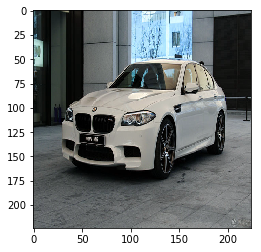

In [44]:
predict('./test_img/c95a21c838d3881dcf47c35fe6acbac910.jpg')

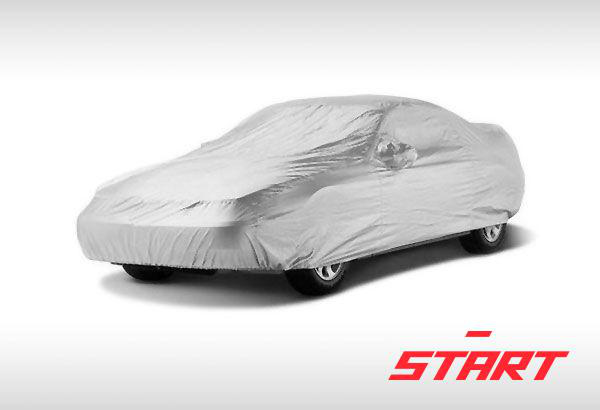

In [3]:
import PIL.Image as o
o.open('/root/playground/START/car_class/start/16/101/767016.jpg')

In [66]:
l2i[y_test[5].argmax()]

'13 1025'

In [69]:
print lookup(bba_info, 'pp_brand_id', '13')['chinese']

马自达


In [39]:
bad_item = ['1/1/688701.jpg',
 '1/16/623069.jpg',
 '1/16/741040_b.jpg',
 '1/16/748100.jpg',
 '1/16/748100_b.jpg',
 '1/20/375938.jpg',
 '1/20/375938_b.jpg',
 '1/20/580147_b.jpg',
 '1/20010/725439.jpg',
 '1/20010/725439_b.jpg',
 '1/20010/752374.jpg',
 '1/22/722879.jpg',
 '1/22/722879_b.jpg',
 '1/22/789904.jpg',
 '1/47/791845_b.jpg',
 '1/48/190339.jpg',
 '1/48/190339_b.jpg',
 '1/48/752925.jpg',
 '1/48/752925_b.jpg',
 '1/48/787935_b.jpg',
 '1/49/415083.jpg',
 '1/49/415083_b.jpg',
 '1/49/702033_b.jpg',
 '1/49/746645.jpg',
 '1/49/746645_b.jpg',
 '1/49/770767.jpg',
 '1/52/485833_b.jpg',
 '1/52/544577_b.jpg',
 '1/52/786903.jpg',
 '1/52/786903_b.jpg',
 '11/20023/733800.jpg',
 '11/20023/733800_b.jpg',
 '11/2443/739262_b.jpg',
 '11/84/783151.jpg',
 '11/84/783151_b.jpg',
 '11/989/675328.jpg',
 '11/989/715597.jpg',
 '11/989/724995.jpg',
 '11/989/724995_b.jpg',
 '12/1221/752691_b.jpg',
 '12/1224/463709_b.jpg',
 '12/55/714568.jpg',
 '12/55/714568_b.jpg',
 '12/55/744158.jpg',
 '12/55/745521_b.jpg',
 '12/61/426908_b.jpg',
 '12/61/716443.jpg',
 '12/61/716443_b.jpg',
 '12/61/722799.jpg',
 '12/61/722799_b.jpg',
 '12/61/803915.jpg',
 '12/63/641106.jpg',
 '12/63/641106_b.jpg',
 '13/1025/529762.jpg',
 '13/1332/770932_b.jpg',
 '13/209/585706.jpg',
 '13/209/784394.jpg',
 '13/2574/516384_b.jpg',
 '13/2575/697253_b.jpg',
 '13/81/214383.jpg',
 '13/81/271307_b.jpg',
 '13/81/407259.jpg',
 '13/81/407259_b.jpg',
 '13/81/439889.jpg',
 '13/81/694495.jpg',
 '13/81/694495_b.jpg',
 '13/81/778592.jpg',
 '13/81/778592_b.jpg',
 '13/81/802644.jpg',
 '13/81/802644_b.jpg',
 '13/82/764446.jpg',
 '13/82/764446_b.jpg',
 '13/976/802389_b.jpg',
 '15/20026/687836_b.jpg',
 '15/472/725828.jpg',
 '15/472/725828_b.jpg',
 '15/482/357839.jpg',
 '15/90/704858.jpg',
 '15/90/704858_b.jpg',
 '18/2567/211508.jpg',
 '18/2567/457263.jpg',
 '18/2567/457263_b.jpg',
 '18/2567/512448.jpg',
 '18/2567/667647_b.jpg',
 '18/2567/672650_b.jpg',
 '18/2567/700197.jpg',
 '18/2567/700197_b.jpg',
 '18/2569/565409.jpg',
 '18/2569/721994.jpg',
 '22/155/453782_b.jpg',
 '22/156/778315.jpg',
 '22/156/778315_b.jpg',
 '22/987/780511.jpg',
 '22/987/780511_b.jpg',
 '27/1078/509519.jpg',
 '27/1078/548380_b.jpg',
 '27/1078/801851.jpg',
 '27/192/223940_b.jpg',
 '27/192/802877_b.jpg',
 '27/193/775460.jpg',
 '27/193/775460_b.jpg',
 '27/194/763274.jpg',
 '27/194/763274_b.jpg',
 '27/508/491077.jpg',
 '27/508/491077_b.jpg',
 '27/508/765328_b.jpg',
 '27/508/776694.jpg',
 '27/508/776694_b.jpg',
 '27/583/712998.jpg',
 '27/583/712998_b.jpg',
 '27/583/766224.jpg',
 '27/596/765959.jpg',
 '27/596/765959_b.jpg',
 '27/609/607726.jpg',
 '27/609/688009.jpg',
 '27/609/688009_b.jpg',
 '27/633/48718.jpg',
 '27/633/48718_b.jpg',
 '31/1308/753268.jpg',
 '31/1308/753268_b.jpg',
 '31/20054/713664.jpg',
 '31/20054/713664_b.jpg',
 '31/20054/776699_b.jpg',
 '31/227/663643_b.jpg',
 '31/228/599712.jpg',
 '31/282/427195.jpg',
 '31/282/427195_b.jpg',
 '31/282/447402_b.jpg',
 '31/282/768380_b.jpg',
 '31/282/796453_b.jpg',
 '31/282/800128_b.jpg',
 '31/815/731081.jpg',
 '31/815/731081_b.jpg',
 '31/815/796331_b.jpg',
 '31/861/594616_b.jpg',
 '31/861/686154.jpg',
 '31/861/686154_b.jpg',
 '31/861/767611.jpg',
 '48/309/665507.jpg',
 '48/309/665507_b.jpg',
 '48/311/778367.jpg',
 '48/311/778367_b.jpg',
 '48/456/801816.jpg',
 '48/456/801816_b.jpg']
for item in bad_item:
    if item[-6] == '_':
        pic = item[:-6]
    else:
        pic = item[:-4]
    #print pic
    try:
        os.remove(os.path.join(data_dir,pic+'.jpg'))
    except:
        pass
    try:
        os.remove(os.path.join(data_dir,pic+'_b.jpg'))
    except:
        pass